In [ ]:
# mounting the google drive where the data csv files downloaded
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import pandas as pd
import numpy as np
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

In [ ]:
x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)

pca = PCA(random_state=42)
x_train_pca = pca.fit_transform(x_train_scaler)

Text(0, 0.5, '% of explained variance')

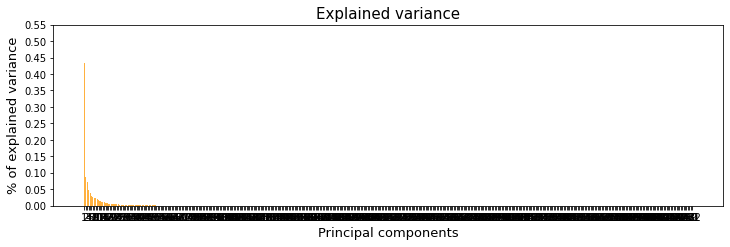

In [ ]:
from prettytable import PrettyTable

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=.4, hspace=.4)

ax = fig.add_subplot(2, 1, 1)
ax.bar(range(1, 1+pca.n_components_),
       pca.explained_variance_ratio_,
       color='#FFB13F')
ax.set(xticks=range(1, 1+pca.n_components_))
plt.yticks(np.arange(0, 0.6, 0.05))
plt.title('Explained variance', fontsize=15)
plt.xlabel('Principal components', fontsize=13)
plt.ylabel('% of explained variance', fontsize=13)

In [ ]:
t = PrettyTable(['Component',
                 'Explained Variance',
                 'Cumulative explained variance'])
principal_component = 1
cum_explained_var = 0

for explained_var in pca.explained_variance_ratio_:
    cum_explained_var += explained_var
    t.add_row([principal_component, explained_var, cum_explained_var])
    principal_component += 1
print(t)

+-----------+------------------------+-------------------------------+
| Component |   Explained Variance   | Cumulative explained variance |
+-----------+------------------------+-------------------------------+
|     1     |   0.4334853121189273   |       0.4334853121189273      |
|     2     |  0.08804626290348938   |       0.5215315750224168      |
|     3     |  0.07254098214274898   |       0.5940725571651657      |
|     4     |  0.04920393812989916   |       0.6432764952950649      |
|     5     |  0.037406176285218994  |       0.680682671580284       |
|     6     |   0.0293024133260433   |       0.7099850849063273      |
|     7     |  0.02694535911915835   |       0.7369304440254856      |
|     8     |  0.024493022082315533  |       0.7614234661078011      |
|     9     |   0.0225379137861635   |       0.7839613798939646      |
|     10    |  0.019482182620140898  |       0.8034435625141055      |
|     11    |  0.01906912319757935   |       0.8225126857116849      |
|     

In [ ]:
x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud
x_test_scaler = scaler.transform(x_test)
x_test_pca = pca.transform(x_test_scaler)

Test ROC Score:  0.7378132450674515
Test confusion_matrix


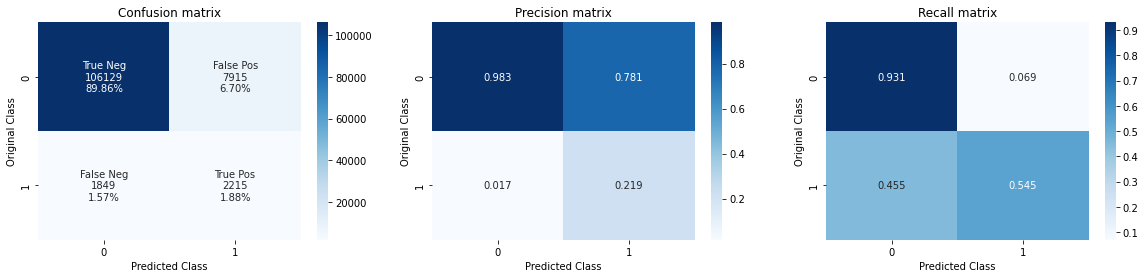

In [ ]:
final_test_pred = {}

model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=19, min_samples_leaf=58, min_samples_split=129,
                       n_estimators=115, n_jobs=-1, random_state=2022)
model.fit(x_train_pca[:, :100],y_train)
test_preds = model.predict(x_test_pca[:, :100])

test_ids = test_data.TransactionID_x.values.tolist()
y_actual = test_data.isFraud
final_test_pred.update(dict(zip(test_ids,test_preds)))
final_test_pred = pd.DataFrame.from_dict(final_test_pred, orient="index").reset_index()
final_test_pred.columns = ["id", "pred_rf"]
final_test_pred['Actual'] = y_actual.values
final_test_pred.to_csv("/gdrive/My Drive/AIML/Project/test_pred_RF.csv", index=False)

ROC_score = roc_auc_score(final_test_pred.Actual, final_test_pred.pred_rf)
print('Test ROC Score: ', ROC_score)

print('Test confusion_matrix')
plot_confusion_matrix(final_test_pred.Actual, final_test_pred.pred_rf)

In [ ]:
def plot_confusion_matrix(y_actual, y_pred):
    #Get the confusion matrix, Precision & Re-call
    conf_matrix = confusion_matrix(y_actual, y_pred)
    recal_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)        
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(prec_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recal_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]

param_dist = {"n_estimators":sp_randint(114,125),
              "max_depth": sp_randint(15,20),
              "min_samples_split": sp_randint(110,145),
              "min_samples_leaf": sp_randint(40,60),
              "criterion": ['gini' , 'entropy']}

clf = RandomForestClassifier(random_state=2022,n_jobs=-1,class_weight='balanced')

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=10,scoring='roc_auc',random_state=2022)

x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

rf_random.fit(x_train,y_train)

print(rf_random.best_estimator_)

print('mean test scores',rf_random.cv_results_['mean_test_score'])

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=19, min_samples_leaf=58, min_samples_split=129,
                       n_estimators=115, n_jobs=-1, random_state=2022)
mean test scores [0.87640523 0.87320511 0.87349703 0.87194447 0.87235205 0.8772915
 0.87325046 0.87269717 0.87514224 0.87363129]


Test ROC Score:  0.7890488919251224
Test confusion_matrix


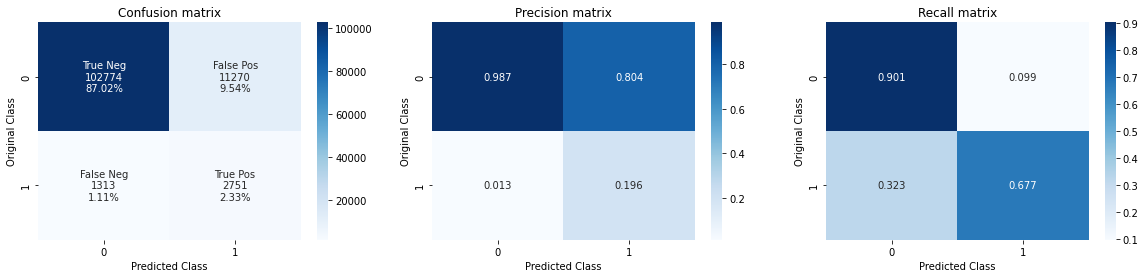

In [ ]:
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]

x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud
final_test_pred = {}

model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=19, min_samples_leaf=58, min_samples_split=129,
                       n_estimators=115, n_jobs=-1, random_state=2022)
model.fit(x_train,y_train)
test_preds = model.predict(x_test)

test_ids = test_data.TransactionID_x.values.tolist()
y_actual = test_data.isFraud
final_test_pred.update(dict(zip(test_ids,test_preds)))
final_test_pred = pd.DataFrame.from_dict(final_test_pred, orient="index").reset_index()
final_test_pred.columns = ["id", "pred_rf"]
final_test_pred['Actual'] = y_actual.values
final_test_pred.to_csv("/gdrive/My Drive/AIML/Project/test_pred_RF.csv", index=False)

ROC_score = roc_auc_score(final_test_pred.Actual, final_test_pred.pred_rf)
print('Test ROC Score: ', ROC_score)

print('Test confusion_matrix')
plot_confusion_matrix(final_test_pred.Actual, final_test_pred.pred_rf)

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]

x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

idx_train = x_train.index[:int(x_train.shape[0]*0.75)]  
idx_validation = x_train.index[int(x_train.shape[0]*0.75):]

clf = XGBClassifier( 
        n_estimators=2000,
        max_depth=21, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1, 
        eval_metric='auc' 
    )
model = clf.fit(x_train.loc[idx_train,useful_cols], y_train[idx_train], 
    eval_set=[(x_train.loc[idx_validation,useful_cols],y_train[idx_validation])],
    verbose=50, early_stopping_rounds=100)


[0]	validation_0-auc:0.835793
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.889599
[100]	validation_0-auc:0.899066
[150]	validation_0-auc:0.907605
[200]	validation_0-auc:0.916782
[250]	validation_0-auc:0.923575
[300]	validation_0-auc:0.926901
[350]	validation_0-auc:0.928744
[400]	validation_0-auc:0.929083
[450]	validation_0-auc:0.93011
[500]	validation_0-auc:0.930408
[550]	validation_0-auc:0.930941
[600]	validation_0-auc:0.931393
[650]	validation_0-auc:0.931652
[700]	validation_0-auc:0.931825
[750]	validation_0-auc:0.931766
[800]	validation_0-auc:0.931958
[850]	validation_0-auc:0.931732
Stopping. Best iteration:
[791]	validation_0-auc:0.932027



AttributeError: ignored

Test ROC Score:  0.6476575072419901
Test confusion_matrix


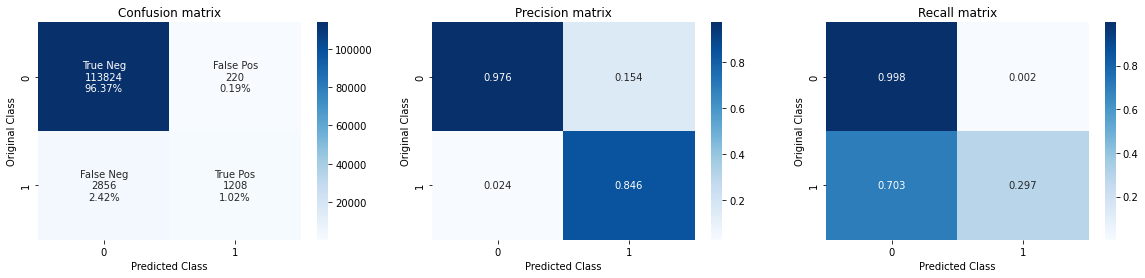

In [ ]:
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]

x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud
final_test_pred = {}

test_preds = model.predict(x_test)

test_ids = test_data.TransactionID_x.values.tolist()
y_actual = test_data.isFraud
final_test_pred.update(dict(zip(test_ids,test_preds)))
final_test_pred = pd.DataFrame.from_dict(final_test_pred, orient="index").reset_index()
final_test_pred.columns = ["id", "pred_xg"]
final_test_pred['Actual'] = y_actual.values
final_test_pred.to_csv("/gdrive/My Drive/AIML/Project/test_pred_xg.csv", index=False)

ROC_score = roc_auc_score(final_test_pred.Actual, final_test_pred.pred_xg)
print('Test ROC Score: ', ROC_score)

print('Test confusion_matrix')
plot_confusion_matrix(final_test_pred.Actual, final_test_pred.pred_xg)

In [ ]:
scores = []
final_valid_predictions={}

for fold in range(3):
    x_train =  train_data[train_data.kfold != fold].reset_index(drop=True)
    x_valid = train_data[train_data.kfold == fold].reset_index(drop=True)

    valid_ids = x_valid.TransactionID_x.values.tolist()
    
    y_train = x_train.isFraud
    y_valid = x_valid.isFraud
    

    x_train = x_train[useful_cols]
    x_valid = x_valid[useful_cols]
       
    model1 = XGBClassifier(random_state=fold, n_jobs=-1)
    model1.fit(x_train, y_train)
    preds_valid = model1.predict(x_valid)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    ROC_score = roc_auc_score(y_valid, preds_valid)
    print(fold, ROC_score)
    scores.append(ROC_score)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("/gdrive/My Drive/AIML/Project/train_pred_1.csv", index=False)

0 0.6487102496969612
1 0.6467916510672247
2 0.6478909454876526
0.6477976154172795 0.0007860398853466278


In [ ]:
final_test_pred = {}
test_ids = test_data.TransactionID_x.values.tolist()
y_actual = test_data.isFraud
x_test = test_data[useful_cols]
test_preds = model1.predict(x_test)
final_test_pred.update(dict(zip(test_ids,test_preds)))
final_test_pred = pd.DataFrame.from_dict(final_test_pred, orient="index").reset_index()
final_test_pred.columns = ["id", "pred_1"]
final_test_pred['Actual'] = y_actual.values
final_test_pred.to_csv("/gdrive/My Drive/AIML/Project/test_pred_1.csv", index=False)

ROC_score = roc_auc_score(final_test_pred.Actual, final_test_pred.pred_1)
print('Test ROC Score: ', ROC_score)

Test ROC Score:  0.6340990963357974


Test confusion_matrix


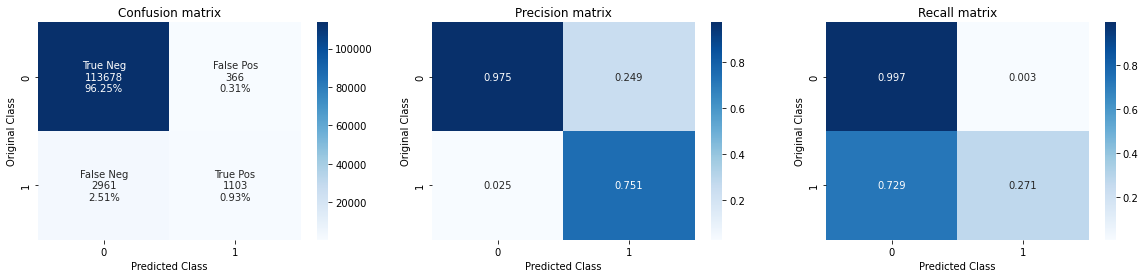

In [ ]:
print('Test confusion_matrix')
plot_confusion_matrix(final_test_pred.Actual, final_test_pred.pred_1)

In [ ]:
estimators = [10,50,100,250,500]
train_scores = []
test_scores = []

train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud

for i in estimators:
    clf = XGBClassifier(max_depth=15, learning_rate = 0.1, max_leaf_nodes=None,
                        booster = 'gbtree', reg_alpha = 0, reg_lambda = 1, subsample = 1, 
                        colsample_bytree= 1, colsample_bylevel=1, colsample_bynode=1, 
                        n_estimators=i, n_jobs=-1,random_state=2022,verbose=0)
    clf.fit(x_train,y_train)
    train_sc = roc_auc_score(y_train,clf.predict(x_train))
    test_sc = roc_auc_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 15')

Estimators =  10 Train Score 0.7505373493753325 test Score 0.6426252467620592
Estimators =  50 Train Score 0.8754535852043711 test Score 0.6785748462328534
Estimators =  100 Train Score 0.9241635324693785 test Score 0.6799279208301148
Estimators =  250 Train Score 0.9627009186528406 test Score 0.6776865045456968
Estimators =  500 Train Score 0.9867461895294898 test Score 0.6801468626075252


In [ ]:
depths = [3,5,8,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(max_depth=i, learning_rate = 0.1, max_leaf_nodes=None,
                        booster = 'gbtree', reg_alpha = 0, reg_lambda = 1, subsample = 1, 
                        colsample_bytree= 1, colsample_bylevel=1, colsample_bynode=1, 
                        n_estimators=115, n_jobs=-1,random_state=2022,verbose=0)
    clf.fit(x_train,y_train)
    train_sc = roc_auc_score(y_train,clf.predict(x_train))
    test_sc = roc_auc_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 115')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cleaned_df = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
test_df = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

neg, pos = np.bincount(cleaned_df['isFraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# You don't want the `Time` column.
cleaned_df.pop('TransactionDT')
cleaned_df.pop('kfold')
cleaned_df.pop('TransactionID_x')
cleaned_df.pop('TransactionID_y')
test_df.pop('TransactionDT')
test_df.pop('kfold')
test_df.pop('TransactionID_x')
test_df.pop('TransactionID_y')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('TransactionAmt')+eps)
test_df['Log Ammount'] = np.log(test_df.pop('TransactionAmt')+eps)

# Use a utility from sklearn to split and shuffle your dataset.
train_df, val_df = train_test_split(cleaned_df, test_size=0.2)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 472432
    Positive: 16599 (3.51% of total)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Weight for class 0: 0.52
Weight for class 1: 14.23


In [ ]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('isFraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('isFraud'))
test_labels = np.array(test_df.pop('isFraud'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (377945, 431)
Validation features shape: (94487, 431)
Test features shape: (118108, 431)
Training labels shape: (377945,)
Validation labels shape: (94487,)
Test labels shape: (118108,)


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc', curve="ROC"),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          256, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          128, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          64, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
            keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
          bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 200
BATCH_SIZE = 4096
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
weighted_model = make_model()
#weighted_model.load_weights(initial_weights)
weighted_model.summary()

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               110592    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                1

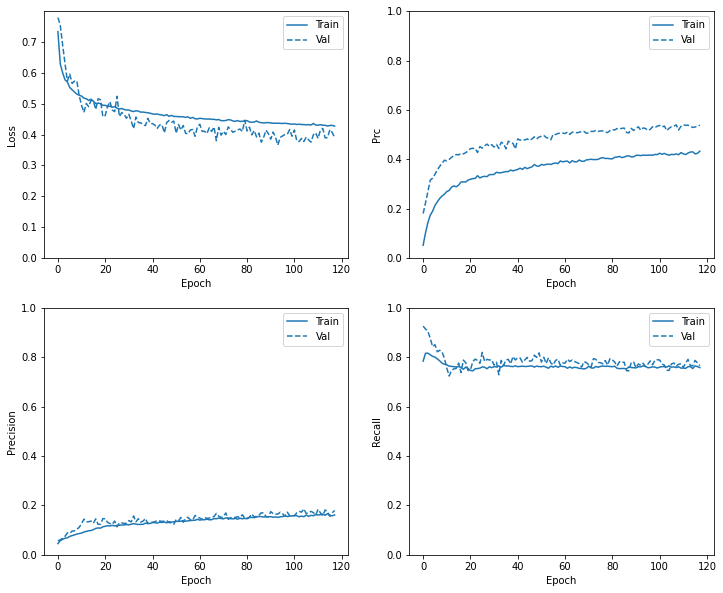

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.40590912103652954
tp :  2814.0
fp :  17390.0
tn :  96654.0
fn :  1250.0
accuracy :  0.8421783447265625
precision :  0.1392793506383896
recall :  0.6924212574958801
auc :  0.8446878790855408
prc :  0.35517287254333496



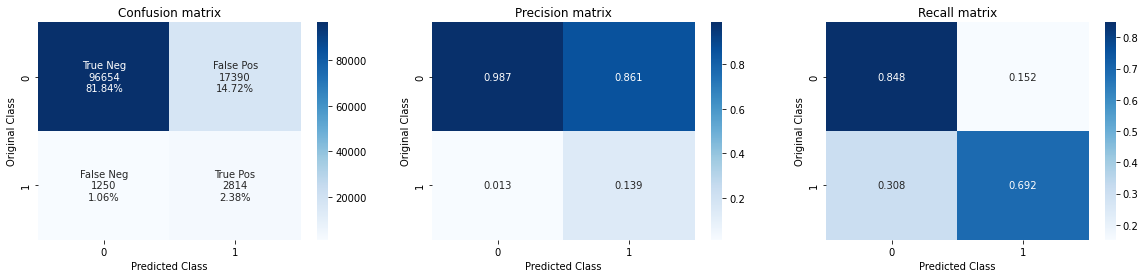

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

#plot_cm(test_labels, test_predictions_weighted)
plot_confusion_matrix(test_labels, test_predictions_weighted >0.5)

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(364650, 431)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape